# Objective

Objective - To identify factors that contribute to a playlist's success using Spotify's playlist level data

**Why** is Spotify interested in understanding the factors contributing to a playlist's success:


1.   Helpful in creating presonalized recommendations, leading to higher user engagement and retention
2.   Finding opportunities for ad-placement (free-users) while nudging them to subscribe premium, leading to increased revenue


# Step 1: Importing Libraries and Importing data from Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#data wrangling
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import skew
import ast
from os import rename

#Data pre-processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Machine Leaning models
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#display
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#datetime
from datetime import datetime
import time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
#read data with tab separater
playlists = pd.read_csv("/content/drive/My Drive/Spotify/playlist_summary_external.txt", sep='\t')

# Step 2 - Data Exploration

## 2.1 Dataset overview

In [4]:
playlists.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,0,US,52,0,4,7,30,27,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",Dance & House,New Age,Country & Folk,Peaceful,Romantic,Somber
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,0,US,131,0,112,113,112,94,"[""good"", ""living""]",Pop,Indie Rock,Alternative,Excited,Yearning,Defiant
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,0,US,43,0,35,36,63,0,"[""norte\u00f1a""]",Latin,-,-,Lively,Upbeat,Romantic
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,0,US,27,1,27,26,154,108,[],Dance & House,Electronica,Pop,Excited,Aggressive,Defiant
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,1,US,52,0,47,51,230,0,"[""cheesy"", ""pants""]",Indie Rock,Alternative,Electronica,Excited,Defiant,Yearning


In [5]:
playlists.dtypes

,0
playlist_uri,object
owner,object
streams,int64
stream30s,int64
dau,int64
wau,int64
mau,int64
mau_previous_month,int64
mau_both_months,int64
users,int64


In [6]:
playlists.isna().sum()

,0
playlist_uri,0
owner,0
streams,0
stream30s,0
dau,0
wau,0
mau,0
mau_previous_month,0
mau_both_months,0
users,0


In [7]:
playlists.shape

(403366, 25)

## 2.2 Categorical data analysis

In [8]:
categorical_cols = playlists.select_dtypes(include=['object']).columns.tolist()
playlists[categorical_cols].describe()

,playlist_uri,owner,owner_country,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
count,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366
unique,403366,314899,1,192107,26,26,26,27,27,27
top,spotify:user:36069af6af076ccd9e597184a67b68c9:...,spotify,US,[],Indie Rock,Alternative,Pop,Defiant,Energizing,Energizing
freq,1,399,403366,32568,70571,66252,78758,81079,51643,56450


- All 403K unique playlists
- 314K unique owners, some owners own multiple playlists
- each type of genre have 26 different values and moods have 27 different values
- Also, displaying the ferquency of most common category in all columns.


- **Important**: For example: **spotify** is the most common owner owning 399 different playlists
- About 70K tokens are missing,
- 70K playlists have Indie Rock as top genre, 81K playlists have Defiant as top mood
- Only 1 country: US


In [9]:
#playlist uri looks like
playlists['playlist_uri'][0].split(':')

['spotify',
 'user',
 '36069af6af076ccd9e597184a67b68c9',
 'playlist',
 '5M8emOIVn1s6pfibDdCYEu']

Refining playlist_uri to playlist_id

In [10]:
#user is already in owner column so keeping only playlist_id and only 1 country so deleteing country variable
playlists['playlist_id'] = playlists['playlist_uri'].str.split(':').str[-1]
categorical_cols = ['playlist_id'] + [col for col in categorical_cols if col not in ['playlist_uri', 'owner_country']]
playlists.drop(columns=['playlist_uri','owner_country'], inplace=True)
playlists = playlists[['playlist_id'] + [col for col in playlists if col != 'playlist_id']]
playlists.head(1)

,playlist_id,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
0,5M8emOIVn1s6pfibDdCYEu,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,0,52,0,4,7,30,27,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",Dance & House,New Age,Country & Folk,Peaceful,Romantic,Somber


Checking missing values in genre and mood

In [11]:
playlists[['genre_1', 'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3']] = playlists[['genre_1', 'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3']].replace('-', np.nan)

In [12]:
missing_cols = playlists.isna().sum()
missing_percentage = round(100*missing_cols[missing_cols > 0]/len(playlists),2)
missing_percentage = missing_percentage.rename('missing_percentage')
missing_percentage

,missing_percentage
genre_1,0.23
genre_2,5.26
genre_3,9.95
mood_1,0.44
mood_2,0.46
mood_3,0.50


Imputing missing values in genre and mood by:


1.   Dataset has 10% missing values for genre_3, 5% missing for genre_2, and only 0.25% missing for genre_1
2.   Grouping at combination of ['mood_1', 'mood_2', 'mood_3'] level and aggregating at ['genre_1'] mode level
3.   Using ['genre_1'] mode to impute for missing ['genre_3','genre_2]
4.   For rest of the missing values (0.5%), labeling them as 'Miscellaneous'
5.   Missing values in all 3 mood columns are only 0.5%, so imputing them with 'Miscellaneous' as well




In [13]:
most_common_genre_1 = playlists.groupby(['mood_1', 'mood_2', 'mood_3'])['genre_1'].apply(lambda x: x.mode()[0])
playlists['common_genre_1_by_mood'] = playlists.set_index(['mood_1', 'mood_2', 'mood_3']).index.map(most_common_genre_1)
playlists['genre_3'] = playlists['genre_3'].fillna(playlists['common_genre_1_by_mood'])
playlists['genre_2'] = playlists['genre_2'].fillna(playlists['common_genre_1_by_mood'])
playlists.drop(columns=['common_genre_1_by_mood'], inplace=True)

In [14]:
#Imputing missing values in genres and moods with Miscellaneous
cols_to_impute = ['genre_1', 'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3']
for col in cols_to_impute:
  playlists[col] = playlists[col].replace(np.nan, 'Miscellaneous')

## 2.3 Numeric data analysis

In [15]:
pd.set_option('display.float_format', '{:.0f}'.format)

numeric_cols = playlists.select_dtypes(exclude=['object']).columns.tolist()
playlists[numeric_cols].describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s
count,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366,403366
mean,71,43,4,22,66,58,13,149,3,201,3,84,88,1260,94
std,6492,3772,359,1615,4733,3827,1241,9247,205,584,40,128,133,106246,226
min,0,0,0,0,2,0,0,2,0,1,0,1,1,2,0
25%,0,0,0,1,2,1,1,2,0,38,0,18,19,31,6
50%,1,0,0,1,2,2,1,3,0,84,0,46,48,79,30
75%,8,5,1,2,4,3,2,7,0,192,0,100,106,193,96
max,2629715,1513237,152929,669966,1944150,1478684,578391,3455406,86162,79984,9117,5226,6397,42497334,25904


In [16]:
print("Distribution of numeric variables\n")

def analyze_distribution(series):
    sk = skew(series)
    skew_str = "right-skewed" if sk > 0 else "left-skewed" if sk < 0 else "symmetric"
    skew_level = "highly" if abs(sk) > 1 else "moderately" if abs(sk) > 0.5 else ""
    return f"{skew_level} {skew_str} distribution"

for col in numeric_cols:
    print(f"{col}: {analyze_distribution(playlists[col])}")

Distribution of numeric variables

streams: highly right-skewed distribution
stream30s: highly right-skewed distribution
dau: highly right-skewed distribution
wau: highly right-skewed distribution
mau: highly right-skewed distribution
mau_previous_month: highly right-skewed distribution
mau_both_months: highly right-skewed distribution
users: highly right-skewed distribution
skippers: highly right-skewed distribution
n_tracks: highly right-skewed distribution
n_local_tracks: highly right-skewed distribution
n_artists: highly right-skewed distribution
n_albums: highly right-skewed distribution
monthly_stream30s: highly right-skewed distribution
monthly_owner_stream30s: highly right-skewed distribution


**Interpretation** :
There are a few playlists having way more number of streams/users/artists/albums/etc than a lot of playlists.


Meaning: most playlists minimal have engagement, but a few highly popular ones attract a significant amount of activity

# Step 3 - Feature Engineering

## 3.1 numeric features

In [17]:
numeric_cols

['streams',
 'stream30s',
 'dau',
 'wau',
 'mau',
 'mau_previous_month',
 'mau_both_months',
 'users',
 'skippers',
 'n_tracks',
 'n_local_tracks',
 'n_artists',
 'n_albums',
 'monthly_stream30s',
 'monthly_owner_stream30s']

### 3.1.1 daily numeric metrics

In [18]:
#percentage of total streams that lasted at least 30 seconds.
playlists['daily_streams_engagement_rate'] = (100 * playlists['stream30s'] / playlists['streams']).fillna(0)

In [19]:
#average number of monthly streams per dau (daily active user)
playlists['daily_streams_per_dau'] = (playlists['stream30s'] / playlists['dau']).fillna(0)

In [20]:
# percentage of tracks added daily
playlists['daily_change_in_track_rate'] = (100 * playlists['n_local_tracks'] / playlists['n_tracks']).fillna(0)

In [21]:
#percentage of dau (daily active user) who skipped tracks
playlists['daily_skip_rate'] = (100 * playlists['skippers'] / playlists['dau']).fillna(0)

In [22]:
# depth of engagement = average number of daily streams per track
playlists['daily_streams_per_track'] = (playlists['stream30s'] / playlists['n_tracks']).fillna(0)

### 3.1.2 monthly numeric metrics

In [23]:
#percentage of total users who were active within past month
playlists['monthly_active_user_rate'] = (100*playlists['mau']/playlists['users']).fillna(0)

In [24]:
#percentage of total monthly streams that were initiated by owner
playlists['owner_monthly_streams_share'] = (100*playlists['monthly_owner_stream30s']/playlists['monthly_stream30s']).fillna(0)

In [25]:
#average number of monthly streams per mau (monthly active user)
playlists['monthly_streams_per_mau'] = (playlists['monthly_stream30s']/playlists['mau']).fillna(0)

In [26]:
#month over month retention rate
playlists['monthly_user_retention_rate'] = (100*playlists['mau_both_months']/playlists['mau_previous_month']).fillna(0)

In [27]:
#user growth percentage from pervious month to current month
playlists['monthly_user_growth_rate'] = (100*(playlists['mau'] - playlists['mau_previous_month'])/playlists['mau_previous_month']).fillna(0)

### 3.1.3 more numeric metrics

In [28]:
#how often monthly active users return weekly
playlists['weekly_stickiness'] = (playlists['wau'] / playlists['mau']).fillna(0)

In [29]:
#average number of tracks per artist
playlists['tracks_per_artist'] = (playlists['n_tracks'] / playlists['n_artists']).fillna(0)

## 3.2 categorical features

In [30]:
categorical_cols

['playlist_id',
 'owner',
 'tokens',
 'genre_1',
 'genre_2',
 'genre_3',
 'mood_1',
 'mood_2',
 'mood_3']

Creating Token features


1.   Created *Token Frequency table* by putting all tokens from all playlists into a cleaned list of tokens then grouping by token.
2.   Identifying *50 popular tokens*: Sorting token frequency table by token frequency in descending order and selecting top 50
3.   ['contains_popular_token']: if a playlist contains at least one of top 50 popular tokens
4.   ['token_score']: sum of frequencies of tokens in a playlist
4.   ['length_of_cleaned_tokens']: number of tokens in a playlist



In [31]:
#creating token frequency table
pd.set_option('display.float_format', '{:.2f}'.format)
def clean_token_list(tokens_str):
    tokens_list = ast.literal_eval(tokens_str)
    return list(dict.fromkeys(word for word in tokens_list if word.isalpha()))
playlists['clean_tokens'] = playlists['tokens'].apply(clean_token_list)
all_clean_tokens = [token for tokens_list in playlists['clean_tokens'] for token in tokens_list]

token_counts = Counter(all_clean_tokens)
popular_tokens_df = pd.DataFrame(token_counts.items(), columns=['token', 'frequency']).sort_values(by='frequency', ascending=False)
popular_tokens_df.head()

,token,frequency
1,music,13789
100,playlist,10040
123,songs,9011
416,country,6838
32,mix,6103


In [32]:
#indicating if playlist token containts trending keywords
popular_tokens = set(popular_tokens_df['token'][:50].tolist())
def contains_popular_token(clean_tokens):
    return 1 if any(token in popular_tokens for token in clean_tokens) else 0
playlists['contains_popular_token'] = playlists['clean_tokens'].apply(contains_popular_token)

In [33]:
#token score based on popular
token_weights = dict(zip(popular_tokens_df['token'], popular_tokens_df['frequency']))
def calculate_token_score(clean_tokens):
    return sum(token_weights.get(token, 0) for token in clean_tokens)
playlists['token_score'] = playlists['clean_tokens'].apply(calculate_token_score)

In [34]:
#number of words in a token in a playlist
def length_of_cleaned_tokens(row):
  return len(row['clean_tokens'])
playlists['length_of_cleaned_tokens'] = playlists.apply(length_of_cleaned_tokens, axis=1)

Creating owner_type:

If a owner is Spotify or Personal user

In [35]:
playlists['owner_type'] = np.where(playlists['owner'].str.contains('spotify'), 'spotify', 'personal')

# Step 4 - Defining **music_taste** feature using **K-means clustering**

## 4.1 Aggregating at genre level to create Genre Metric


1.   Temporarily transforming playlist so it will have only 1 genre column by stacking other 2 genres columns to the bottom of it
2.   Grouping using the *only genre column*
3.   Aggregating by playlist_count and monthly_streams_per_mau (derived based on monthly_streams30s above)
4.   Strandardizing both metric
5. Created a combined **Genre metric** by assiginng equal weights to each individual metric




In [36]:
#Temporarily transforming playlist so it will have only 1 genre column and other2 genres stacked to the bottom of it
playlists1 = playlists#[playlists['owner']!='spotify']
pg1 = playlists1[['playlist_id','genre_1','monthly_stream30s','mau','monthly_streams_per_mau']]
pg1.rename(columns={'genre_1':'genre'}, inplace=True)
pg2 = playlists1[['playlist_id','genre_2','monthly_stream30s','mau','monthly_streams_per_mau']]
pg2.rename(columns={'genre_2':'genre'}, inplace=True)
pg3 = playlists1[['playlist_id','genre_3','monthly_stream30s','mau','monthly_streams_per_mau']]
pg3.rename(columns={'genre_3':'genre'}, inplace=True)
pg = pd.concat([pg1,pg2,pg3])

#grouping using the only genre column
pg_grouped = pg.groupby(['genre']).agg({'playlist_id':'count','monthly_streams_per_mau':'median'}).reset_index()
pg_grouped.rename(columns={'playlist_id':'playlist_count',
                           'monthly_streams_per_mau':'median_streams_per_mau'}, inplace=True)

#Standardizing the individual metrics
scaler = MinMaxScaler()
pg_grouped[['Reach Metric', 'Engagement Metric']] = scaler.fit_transform(pg_grouped[['playlist_count', 'median_streams_per_mau']])

#Creating a combined metric: Genre Metric by taking weighted average
w_reach = 0.5
w_engagement = 0.5
pg_grouped['Genre Metric'] = (w_reach * pg_grouped['Reach Metric']) + (w_engagement * pg_grouped['Engagement Metric'])
pg_grouped = pg_grouped.sort_values(by='Genre Metric', ascending=False).reset_index(drop=True)
pg_grouped

,genre,playlist_count,median_streams_per_mau,Reach Metric,Engagement Metric,Genre Metric
0,Pop,211694,25.00,1.00,0.83,0.91
1,Alternative,141155,28.00,0.67,1.00,0.83
2,Indie Rock,140056,27.00,0.66,0.94,0.80
3,Rock,114428,25.00,0.54,0.83,0.68
4,Rap,119460,23.50,0.56,0.74,0.65
5,Dance & House,83505,25.50,0.39,0.86,0.62
6,Electronica,74011,25.33,0.35,0.85,0.60
7,R&B,93375,22.50,0.44,0.69,0.56
8,Country & Folk,47623,24.50,0.22,0.80,0.51
9,Spoken & Audio,5876,26.36,0.02,0.91,0.47


## 4.2 Aggregating at mood level to create Mood Metric

Repeating steps 1 to 5 in 4.1 to create a **Mood metric** at mood level

In [37]:
#Temporarily transforming playlist so it will have only 1 mood column and other 2 moods stacked to the bottom of it
playlists1 = playlists#[playlists['owner']!='spotify']
pm1 = playlists1[['playlist_id','mood_1','monthly_stream30s','mau','monthly_streams_per_mau']]
pm1.rename(columns={'mood_1':'mood'}, inplace=True)
pm2 = playlists1[['playlist_id','mood_2','monthly_stream30s','mau','monthly_streams_per_mau']]
pm2.rename(columns={'mood_2':'mood'}, inplace=True)
pm3 = playlists1[['playlist_id','mood_3','monthly_stream30s','mau','monthly_streams_per_mau']]
pm3.rename(columns={'mood_3':'mood'}, inplace=True)
pm = pd.concat([pm1,pm2,pm3])

#grouping using the only genre column
pm_grouped = pm.groupby(['mood']).agg({'playlist_id':'count','monthly_streams_per_mau':'median'}).reset_index()
pm_grouped.rename(columns={'playlist_id':'playlist_count',
                           'monthly_streams_per_mau':'median_streams_per_mau'}, inplace=True)

#Standardizing the individual metrics
scaler = MinMaxScaler()
pm_grouped[['Reach Metric', 'Engagement Metric']] = scaler.fit_transform(pm_grouped[['playlist_count', 'median_streams_per_mau']])

#Creating a combined metric: Genre Metric by taking weighted average
w_reach = 0.5
w_engagement = 0.5
pm_grouped['Mood Metric'] = (w_reach * pm_grouped['Reach Metric']) + (w_engagement * pm_grouped['Engagement Metric'])
pm_grouped = pm_grouped.sort_values(by='Mood Metric', ascending=False).reset_index(drop=True)
pm_grouped

,mood,playlist_count,median_streams_per_mau,Reach Metric,Engagement Metric,Mood Metric
0,Defiant,149564,26.00,1.00,0.84,0.92
1,Excited,137442,27.50,0.92,0.92,0.92
2,Yearning,115373,29.00,0.76,1.00,0.88
3,Energizing,132480,24.50,0.88,0.75,0.82
4,Empowering,91666,26.00,0.60,0.84,0.72
5,Brooding,69214,26.00,0.45,0.84,0.64
6,Urgent,64467,24.95,0.41,0.78,0.60
7,Sensual,71829,23.00,0.46,0.67,0.57
8,Cool,68697,22.67,0.44,0.65,0.55
9,Upbeat,46980,25.08,0.29,0.79,0.54


## 4.3 Transforming both metrics to Playlist level

Applying the calculating Genre metric back to 400,000 rows playlist level data to each of 3 genre columns and 3 mood columns

In [38]:
for col in ['genre_1','genre_2', 'genre_3']:
    playlists[f'{col}_metric'] = playlists[col].map(pg_grouped.set_index('genre')['Genre Metric'])

for col in ['mood_1','mood_2', 'mood_3']:
    playlists[f'{col}_metric'] = playlists[col].map(pm_grouped.set_index('mood')['Mood Metric'])

encoded_features = playlists[[f'{col}_metric' for col in ['genre_1','genre_2', 'genre_3', 'mood_1','mood_2', 'mood_3']]]

## 4.4 Applying K-Means to identify optimal cluster size



1.   Scaling all ['genre_1','genre_2', 'genre_3', 'mood_1','mood_2', 'mood_3'] columns at playlist level data
2.   Applying K-means, iterating from 2 to 25 clusters to find the optimal cluster size

In [39]:
scaler = MinMaxScaler()
encoded_features_scaled = scaler.fit_transform(encoded_features)

inertia = []
cluster_range = range(2, 25)  # Trying cluster sizes from 2 to 25

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_features_scaled)
    inertia.append(kmeans.inertia_)

Elbow plot to identify optimal number of clusters for music_taste.

Choosing Cluster size = 15

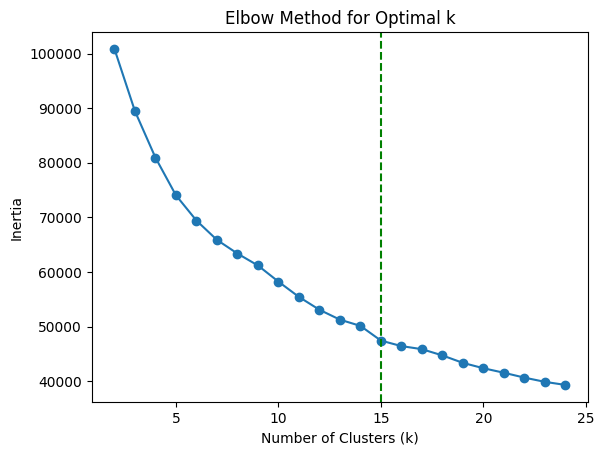

In [40]:
# Plot the elbow curve
plt.plot(cluster_range, inertia, marker='o')
plt.axvline(x=15, color='green', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

## 4.5 Predicting the cluster number for each playlist

In [41]:
k_optimal = 15
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
playlists['music_cluster'] = kmeans.fit_predict(encoded_features_scaled)

## 4.6 Giving a meaningful name to each of music cluster

 Naming the cluster by identifying the top 3 most popular genres and top 3 most popular moods within each cluster

In [42]:
cluster_summary = playlists.groupby('music_cluster').agg({
    'genre_1': lambda x: x.mode()[0],
    'genre_2': lambda x: x.mode()[0],
    'genre_3': lambda x: x.mode()[0],
    'mood_1': lambda x: x.mode()[0],
    'mood_2': lambda x: x.mode()[0],
    'mood_3': lambda x: x.mode()[0]
}).reset_index()

cluster_summary['Dominant Genres'] = cluster_summary[['genre_1', 'genre_2', 'genre_3']].agg(', '.join, axis=1)
cluster_summary['Dominant Moods'] = cluster_summary[['mood_1', 'mood_2', 'mood_3']].agg(', '.join, axis=1)
cluster_summary[['music_cluster', 'Dominant Genres', 'Dominant Moods']]

,music_cluster,Dominant Genres,Dominant Moods
0,0,"Indie Rock, Pop, Pop","Empowering, Gritty, Gritty"
1,1,"Rap, R&B, Pop","Defiant, Energizing, Cool"
2,2,"Rap, R&B, Pop","Defiant, Cool, Energizing"
3,3,"Latin, Latin, Latin","Lively, Romantic, Miscellaneous"
4,4,"Indie Rock, Alternative, Pop","Sensual, Yearning, Energizing"
5,5,"Pop, Rap, R&B","Excited, Energizing, Energizing"
6,6,"Indie Rock, Rock, Pop","Sensual, Yearning, Rowdy"
7,7,"Indie Rock, Rock, Pop","Sensual, Rowdy, Yearning"
8,8,"Indie Rock, Alternative, Rock","Excited, Yearning, Urgent"
9,9,"Latin, Pop, Jazz","Lively, Romantic, Romantic"


Assigning a meaningful name to each cluster

In [43]:
music_taste = [
    "Indie Pop Empowerment",
    "Defiant R&B Pop",
    "Urban Cool Beats",
    "Romantic Latin Tunes",
    "Sensual Indie Alt",
    "Energized Pop Rap",
    "Yearning Indie Rock",
    "Rowdy Indie Rock",
    "Urgent Alt Rock",
    "Latin Jazz Romance",
    "Energized Indie Rock",
    "Cinematic Urban Beats",
    "Empowered Religious Pop",
    "Sophisticated Country",
    "Vibrant Latin Jazz"
]
cluster_summary["Music Taste"] = music_taste
cluster_summary[['music_cluster', 'Dominant Genres', 'Dominant Moods','Music Taste']]

,music_cluster,Dominant Genres,Dominant Moods,Music Taste
0,0,"Indie Rock, Pop, Pop","Empowering, Gritty, Gritty",Indie Pop Empowerment
1,1,"Rap, R&B, Pop","Defiant, Energizing, Cool",Defiant R&B Pop
2,2,"Rap, R&B, Pop","Defiant, Cool, Energizing",Urban Cool Beats
3,3,"Latin, Latin, Latin","Lively, Romantic, Miscellaneous",Romantic Latin Tunes
4,4,"Indie Rock, Alternative, Pop","Sensual, Yearning, Energizing",Sensual Indie Alt
5,5,"Pop, Rap, R&B","Excited, Energizing, Energizing",Energized Pop Rap
6,6,"Indie Rock, Rock, Pop","Sensual, Yearning, Rowdy",Yearning Indie Rock
7,7,"Indie Rock, Rock, Pop","Sensual, Rowdy, Yearning",Rowdy Indie Rock
8,8,"Indie Rock, Alternative, Rock","Excited, Yearning, Urgent",Urgent Alt Rock
9,9,"Latin, Pop, Jazz","Lively, Romantic, Romantic",Latin Jazz Romance


Mapping the cluster name  **music_style** back to playlist level data

In [44]:
playlists['music_cluster'] = playlists['music_cluster'].map(cluster_summary.set_index('music_cluster')['Music Taste'])

## 4.7 Cluster level Insights

In [45]:
playlists.groupby('music_cluster').agg({'playlist_id':'count',
                                     'streams':'median',
                                     'stream30s':'median',
                                     'monthly_owner_stream30s':'median',
                                     'monthly_stream30s':'median',

                                     'dau':'median',
                                     'wau':'median',
                                     'mau':'median',
                                     'mau_both_months':'median',
                                     'users':'median',

                                     'n_artists':'median',
                                     'n_tracks':'median',
                                     'n_local_tracks':'median',
                                     'n_albums':'median',

                                     'daily_streams_engagement_rate':'median',
                                     'daily_streams_per_dau':'median',
                                     'daily_change_in_track_rate':'median',
                                     'daily_skip_rate':'median',
                                     'daily_streams_per_track':'median',

                                     'monthly_active_user_rate':'median',
                                     'owner_monthly_streams_share':'median',
                                     'monthly_streams_per_mau':'median',
                                     'monthly_user_retention_rate':'median',
                                     'monthly_user_growth_rate':'median',

                                     'weekly_stickiness':'median',
                                     'tracks_per_artist':'median',
                                     'contains_popular_token':'mean',
                                     'token_score':'median',
                                     'length_of_cleaned_tokens':'median'
                                     }).reset_index().sort_values(by='monthly_stream30s', ascending=False)

,music_cluster,playlist_id,streams,stream30s,monthly_owner_stream30s,monthly_stream30s,dau,wau,mau,mau_both_months,users,n_artists,n_tracks,n_local_tracks,n_albums,daily_streams_engagement_rate,daily_streams_per_dau,daily_change_in_track_rate,daily_skip_rate,daily_streams_per_track,monthly_active_user_rate,owner_monthly_streams_share,monthly_streams_per_mau,monthly_user_retention_rate,monthly_user_growth_rate,weekly_stickiness,tracks_per_artist,contains_popular_token,token_score,length_of_cleaned_tokens
4,Energized Pop Rap,41848,1.00,1.00,43.00,91.00,1.00,1.00,2.00,1.00,3.00,74.00,110.00,0.00,78.00,14.29,1.00,0.00,0.00,0.00,75.00,62.50,31.50,66.67,50.00,0.50,1.25,0.35,477.00,1.00
13,Vibrant Latin Jazz,11912,1.00,0.00,24.00,91.00,0.00,1.00,3.00,1.00,6.00,31.00,78.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00,53.75,39.39,19.50,33.33,25.00,0.40,2.21,0.24,401.00,2.00
2,Empowered Religious Pop,22634,1.00,0.00,30.00,87.00,0.00,1.00,2.00,1.00,4.00,38.00,84.00,0.00,42.00,0.00,0.00,0.00,0.00,0.00,66.67,51.40,25.00,50.00,37.50,0.50,2.07,0.36,589.00,2.00
6,Latin Jazz Romance,12676,1.00,0.00,23.00,86.00,0.00,1.00,3.00,1.00,6.00,24.00,69.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,54.55,40.01,19.25,33.33,33.33,0.40,2.44,0.24,343.00,2.00
11,Urban Cool Beats,39672,1.00,1.00,36.00,86.00,1.00,1.00,2.00,1.00,3.00,69.00,112.00,0.00,69.00,17.96,1.00,0.00,0.00,0.00,66.67,58.82,27.50,60.00,40.00,0.50,1.33,0.35,480.00,2.00
12,Urgent Alt Rock,49847,1.00,0.00,35.00,82.00,0.00,1.00,2.00,1.00,3.00,60.00,99.00,0.00,66.00,0.00,0.00,0.00,0.00,0.00,75.00,58.82,28.00,66.67,50.00,0.50,1.40,0.34,468.00,2.00
3,Energized Indie Rock,36760,1.00,0.00,35.00,81.00,0.00,1.00,2.00,1.00,3.00,55.00,93.00,0.00,59.00,0.00,0.00,0.00,0.00,0.00,75.00,60.00,28.00,60.00,50.00,0.50,1.43,0.33,413.00,2.00
9,Sensual Indie Alt,37961,1.00,0.00,31.00,78.00,0.00,1.00,2.00,1.00,3.00,51.00,90.00,0.00,55.00,0.00,0.00,0.00,0.00,0.00,71.43,55.74,25.67,50.00,50.00,0.50,1.53,0.34,476.00,2.00
1,Defiant R&B Pop,34303,1.00,0.00,31.00,77.00,0.00,1.00,2.00,1.00,3.00,55.00,89.00,0.00,57.00,0.00,0.00,0.00,0.00,0.00,71.43,56.25,25.00,50.00,50.00,0.50,1.30,0.32,407.00,2.00
7,Romantic Latin Tunes,13410,1.00,0.00,14.00,74.00,0.00,1.00,3.00,1.00,7.00,8.00,37.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,50.99,27.27,15.00,25.00,25.00,0.34,4.33,0.17,246.00,2.00


# Step 5 - Spotify-owned vs Personal playlist Analysis

## 5.1 Comparing metrics' distributions across Spotify vs Personal playlists

In [46]:
playlists[playlists['owner']=='spotify'].describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,daily_streams_engagement_rate,daily_streams_per_dau,daily_change_in_track_rate,daily_skip_rate,daily_streams_per_track,monthly_active_user_rate,owner_monthly_streams_share,monthly_streams_per_mau,monthly_user_retention_rate,monthly_user_growth_rate,weekly_stickiness,tracks_per_artist,contains_popular_token,token_score,length_of_cleaned_tokens,genre_1_metric,genre_2_metric,genre_3_metric,mood_1_metric,mood_2_metric,mood_3_metric
count,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00,399.00
mean,50613.37,31191.87,3221.94,16695.06,51858.42,45209.10,10019.18,117791.80,2122.81,85.32,0.07,57.15,59.37,916431.62,1.49,65.18,8.21,0.05,83.56,422.70,40.86,0.18,12.59,14.86,inf,0.29,5.44,0.44,2674.96,2.11,0.67,0.69,0.69,0.63,0.63,0.60
std,198887.91,115255.61,10881.34,48252.99,140532.85,111779.54,37988.59,267252.07,6112.71,88.04,0.69,40.90,43.05,3237110.80,3.70,13.94,2.68,0.38,29.69,1749.31,12.96,2.64,5.19,13.02,NaN,0.13,25.87,0.50,3496.31,0.87,0.20,0.18,0.19,0.24,0.24,0.25
min,0.00,0.00,0.00,0.00,2.00,0.00,0.00,2.00,0.00,10.00,0.00,1.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,2.03,0.00,1.00,0.00,-96.49,0.00,1.00,0.00,0.00,0.00,0.13,0.19,0.19,0.10,0.10,0.00
25%,1361.50,885.50,131.50,843.00,3334.50,2248.00,212.00,9465.00,117.50,40.00,0.00,32.00,33.00,32376.50,0.00,56.38,6.48,0.00,64.92,16.52,32.60,0.00,9.10,9.09,-12.55,0.23,1.03,0.00,253.00,2.00,0.51,0.60,0.60,0.48,0.42,0.37
50%,6794.00,4602.00,583.00,3731.00,13059.00,10741.00,1383.00,31699.00,462.00,59.00,0.00,47.00,49.00,154812.00,0.00,66.90,8.12,0.00,79.04,73.21,39.34,0.00,12.03,12.95,8.66,0.27,1.09,0.00,1250.00,2.00,0.68,0.68,0.68,0.60,0.64,0.64
75%,29298.50,19410.00,2271.50,13267.50,43967.50,39007.50,5510.50,113226.50,1682.50,98.00,0.00,72.50,76.50,595835.00,1.00,75.70,9.87,0.00,100.00,269.53,46.85,0.00,15.03,17.28,38.47,0.33,1.60,1.00,4059.00,2.50,0.80,0.83,0.83,0.88,0.88,0.82
max,2629715.00,1513237.00,152929.00,669966.00,1944150.00,1478684.00,578391.00,3455406.00,86162.00,1000.00,10.00,280.00,319.00,42497334.00,44.00,100.00,18.80,3.70,325.00,28653.41,100.00,50.00,35.52,100.00,inf,1.00,296.00,1.00,19306.00,5.00,0.91,0.91,0.91,0.92,0.92,0.92


In [47]:
playlists[playlists['owner']!='spotify'].describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,daily_streams_engagement_rate,daily_streams_per_dau,daily_change_in_track_rate,daily_skip_rate,daily_streams_per_track,monthly_active_user_rate,owner_monthly_streams_share,monthly_streams_per_mau,monthly_user_retention_rate,monthly_user_growth_rate,weekly_stickiness,tracks_per_artist,contains_popular_token,token_score,length_of_cleaned_tokens,genre_1_metric,genre_2_metric,genre_3_metric,mood_1_metric,mood_2_metric,mood_3_metric
count,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00,402967.00
mean,20.97,11.99,1.23,5.28,14.86,13.48,3.03,32.82,0.73,201.60,3.09,83.88,88.25,354.33,93.65,33.44,4.52,1.18,inf,0.16,72.44,51.07,50.44,57.15,inf,0.46,11.89,0.32,2323.84,1.79,0.65,0.67,0.67,0.71,0.66,0.64
std,766.26,404.19,41.23,185.71,504.70,548.73,129.63,1157.60,27.05,584.35,40.35,128.21,133.25,10935.59,226.34,40.00,12.33,5.08,NaN,5.33,26.16,34.35,97.68,39.20,NaN,0.25,99.04,0.47,3915.89,1.21,0.20,0.20,0.21,0.24,0.23,0.23
min,0.00,0.00,0.00,0.00,2.00,0.00,0.00,2.00,0.00,1.00,0.00,1.00,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,2.08,0.00,1.00,0.00,-96.88,0.00,1.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.00
25%,0.00,0.00,0.00,1.00,2.00,1.00,1.00,2.00,0.00,38.00,0.00,18.00,19.00,31.00,6.00,0.00,0.00,0.00,0.00,0.00,50.00,17.54,10.50,20.00,0.00,0.33,1.17,0.00,30.00,1.00,0.56,0.56,0.56,0.55,0.54,0.54
50%,1.00,0.00,0.00,1.00,2.00,2.00,1.00,3.00,0.00,84.00,0.00,46.00,48.00,79.00,30.00,0.00,0.00,0.00,0.00,0.00,66.67,53.93,24.00,50.00,50.00,0.50,1.55,0.00,443.00,2.00,0.65,0.68,0.68,0.82,0.64,0.64
75%,8.00,5.00,1.00,2.00,4.00,3.00,2.00,7.00,0.00,192.00,0.00,101.00,106.00,193.00,96.00,73.08,4.80,0.00,0.00,0.05,100.00,84.13,56.00,100.00,100.00,0.50,2.94,1.00,2697.00,2.00,0.80,0.83,0.83,0.92,0.88,0.82
max,293283.00,173753.00,18290.00,71891.00,206756.00,190026.00,59049.00,439699.00,11755.00,79984.00,9117.00,5226.00,6397.00,5098585.00,25904.00,100.00,2182.75,100.00,inf,2555.00,100.00,99.99,12477.38,100.00,inf,1.00,17272.00,1.00,49833.00,33.00,0.91,0.91,0.91,0.92,0.92,0.92


## 5.2 Comparing metrics' performance across Spotify vs Personal playlists

In [48]:
playlists.groupby('owner_type').agg({'playlist_id':'count',
                                     'streams':'median',
                                     'stream30s':'median',
                                     'monthly_owner_stream30s':'median',
                                     'monthly_stream30s':'median',

                                     'dau':'median',
                                     'wau':'median',
                                     'mau':'median',
                                     'mau_both_months':'median',
                                     'users':'median',

                                     'n_artists':'median',
                                     'n_tracks':'median',
                                     'n_local_tracks':'median',
                                     'n_albums':'median',

                                     'daily_streams_engagement_rate':'median',
                                     'daily_streams_per_dau':'median',
                                     'daily_change_in_track_rate':'median',
                                     'daily_skip_rate':'median',
                                     'daily_streams_per_track':'median',

                                     'monthly_active_user_rate':'median',
                                     'owner_monthly_streams_share':'median',
                                     'monthly_streams_per_mau':'median',
                                     'monthly_user_retention_rate':'median',
                                     'monthly_user_growth_rate':'median',

                                     'weekly_stickiness':'median',
                                     'tracks_per_artist':'median',
                                     'contains_popular_token':'mean',
                                     'token_score':'median',
                                     'length_of_cleaned_tokens':'median'
                                     }).reset_index()

,owner_type,playlist_id,streams,stream30s,monthly_owner_stream30s,monthly_stream30s,dau,wau,mau,mau_both_months,users,n_artists,n_tracks,n_local_tracks,n_albums,daily_streams_engagement_rate,daily_streams_per_dau,daily_change_in_track_rate,daily_skip_rate,daily_streams_per_track,monthly_active_user_rate,owner_monthly_streams_share,monthly_streams_per_mau,monthly_user_retention_rate,monthly_user_growth_rate,weekly_stickiness,tracks_per_artist,contains_popular_token,token_score,length_of_cleaned_tokens
0,personal,402967,1.00,0.00,30.00,79.00,0.00,1.00,2.00,1.00,3.00,46.00,84.00,0.00,48.00,0.00,0.00,0.00,0.00,0.00,66.67,53.93,24.00,50.00,50.00,0.50,1.55,0.32,443.00,2.00
1,spotify,399,6794.00,4602.00,0.00,154812.00,583.00,3731.00,13059.00,1383.00,31699.00,47.00,59.00,0.00,49.00,66.90,8.12,0.00,79.04,73.21,39.34,0.00,12.03,12.95,8.66,0.27,1.09,0.44,1250.00,2.00


## 5.3 Personal (non-Spotify) owners owning at least 10 playlists

In [49]:
# total (non-Spotify) owners owning at least 10 playlists
non_spotify_owners = playlists[playlists['owner_type']!='spotify'].groupby('owner').size().reset_index(name='playlist_count').sort_values(by='playlist_count', ascending=False)
contributing_owners = non_spotify_owners[non_spotify_owners['playlist_count']>=10]
contributing_owners['playlist_count'].sum()

5415

Insights on non-Spotify playlist owners, segmented based on whether they own 10 or more playlists

In [50]:
playlists['owns_10+_playlists'] = np.where(playlists['owner'].isin(contributing_owners['owner']), 1, 0)
playlists[playlists['owner_type']!='spotify'].groupby('owns_10+_playlists').agg({'playlist_id':'count',
                                     'streams':'median',
                                     'stream30s':'median',
                                     'monthly_owner_stream30s':'median',
                                     'monthly_stream30s':'median',

                                     'dau':'median',
                                     'wau':'median',
                                     'mau':'median',
                                     'mau_both_months':'median',
                                     'users':'median',

                                     'n_artists':'median',
                                     'n_tracks':'median',
                                     'n_local_tracks':'median',
                                     'n_albums':'median',

                                     'daily_streams_engagement_rate':'median',
                                     'daily_streams_per_dau':'median',
                                     'daily_change_in_track_rate':'median',
                                     'daily_skip_rate':'median',
                                     'daily_streams_per_track':'median',

                                     'monthly_active_user_rate':'median',
                                     'owner_monthly_streams_share':'median',
                                     'monthly_streams_per_mau':'median',
                                     'monthly_user_retention_rate':'median',
                                     'monthly_user_growth_rate':'median',

                                     'weekly_stickiness':'median',
                                     'tracks_per_artist':'median',
                                     'contains_popular_token':'mean',
                                     'token_score':'median',
                                     'length_of_cleaned_tokens':'median'
                                     }).rename(columns={'playlist_id':'playlist_count'}).reset_index()

,owns_10+_playlists,playlist_count,streams,stream30s,monthly_owner_stream30s,monthly_stream30s,dau,wau,mau,mau_both_months,users,n_artists,n_tracks,n_local_tracks,n_albums,daily_streams_engagement_rate,daily_streams_per_dau,daily_change_in_track_rate,daily_skip_rate,daily_streams_per_track,monthly_active_user_rate,owner_monthly_streams_share,monthly_streams_per_mau,monthly_user_retention_rate,monthly_user_growth_rate,weekly_stickiness,tracks_per_artist,contains_popular_token,token_score,length_of_cleaned_tokens
0,0,397552,1.00,0.00,30.00,79.00,0.00,1.00,2.00,1.00,3.00,46.00,85.00,0.00,49.00,0.00,0.00,0.00,0.00,0.00,66.67,54.55,24.50,50.00,50.00,0.50,1.55,0.32,443.00,2.00
1,1,5415,0.00,0.00,5.00,43.00,0.00,1.00,3.00,1.00,6.00,22.00,38.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,57.14,15.38,10.50,25.00,50.00,0.38,1.26,0.30,447.00,2.00


# Assumptions



1.   If a playlist is either Viral or Evergreen or Niche, it's assumed to be successful
2.   Today's user/streams are a good representation of daily level metrics
3.   User-base is Top 10% playlists by MAU (MAU>9), rest of the playlists will not be considered for further analysis
4.   Loss on the somewhat variability across genres & moods in Music_taste Clusters created through K-Means Clustering
5. More... (to write later)



# Step 6 : Success Metric Definition

## 6.1 Definfing user-base

Considering only Top 10% users by Monthly Active Users (MAU)

MAU at 90th percentile is 9 in this data, so keeping only those playlists having at least 9 MAUs for further analysis

In [51]:
#percentile distribution of MAU
playlists['mau'].describe(percentiles=[0.25,0.50,0.75,0.8,0.9,0.95])

,mau
count,403366.00
mean,66.14
std,4732.58
min,2.00
25%,2.00
50%,2.00
75%,4.00
80%,4.00
90%,9.00
95%,21.00


In [52]:
MAU_at_90th_percentile = playlists['mau'].quantile(0.90)
MAU_at_90th_percentile

9.0

In [53]:
# Keeping the user-base to top 10% MAU playlists
main_playlists = playlists[playlists['mau'] > MAU_at_90th_percentile]
main_playlists.to_csv('/content/drive/My Drive/Spotify/main_playlists.csv', index=False)
main_playlists.shape

(40032, 49)

In [54]:
#Just saving and reading again to avoid re-running the whole previous code in-case of frequent session outs
main_playlists = pd.read_csv('/content/drive/My Drive/Spotify/main_playlists.csv')

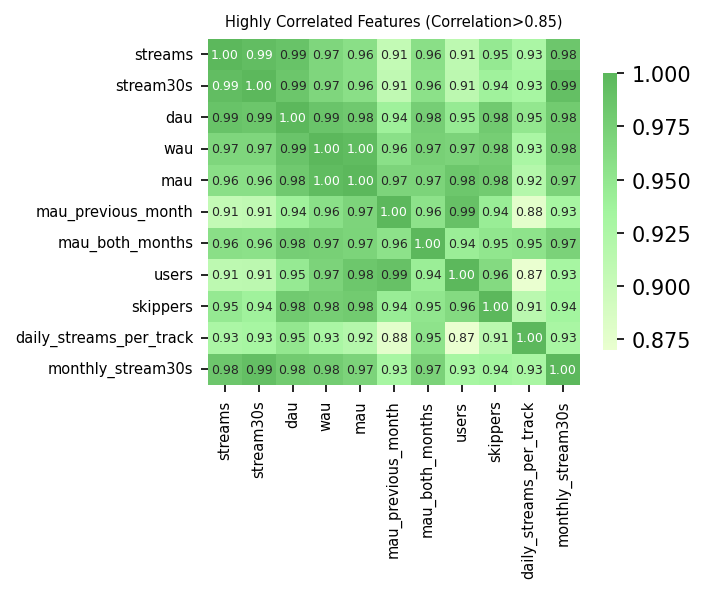

In [55]:
correlation_matrix = main_playlists[['streams', 'stream30s', 'dau', 'wau', 'mau',
       'mau_previous_month', 'mau_both_months', 'users', 'skippers',
       'daily_streams_per_track', 'monthly_stream30s']].corr()

from matplotlib.colors import LinearSegmentedColormap

light_green_cmap = LinearSegmentedColormap.from_list("lightgreens", ["#eaffd0", "#a3f59f", "#5cb85c"])
filtered_corr = correlation_matrix[correlation_matrix >= 0.85]

#Heatmap
plt.figure(figsize=(4, 3), dpi=150)
sns.heatmap(
    filtered_corr,
    annot=True,
    cmap=light_green_cmap,
    fmt=".2f",
    annot_kws={"size": 6},  # Decrease font size for annotations
    cbar_kws={"shrink": 0.8}  # Optional: Shrink color bar size
)
plt.title('Highly Correlated Features (Correlation>0.85)', fontsize=7)  # Decrease title font size
plt.xticks(fontsize=7)  # Decrease x-axis tick font size
plt.yticks(fontsize=7)  # Decrease y-axis tick font size
plt.show()


In [56]:
main_playlists.columns

Index(['playlist_id', 'owner', 'streams', 'stream30s', 'dau', 'wau', 'mau',
       'mau_previous_month', 'mau_both_months', 'users', 'skippers',
       'n_tracks', 'n_local_tracks', 'n_artists', 'n_albums',
       'monthly_stream30s', 'monthly_owner_stream30s', 'tokens', 'genre_1',
       'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3',
       'daily_streams_engagement_rate', 'daily_streams_per_dau',
       'daily_change_in_track_rate', 'daily_skip_rate',
       'daily_streams_per_track', 'monthly_active_user_rate',
       'owner_monthly_streams_share', 'monthly_streams_per_mau',
       'monthly_user_retention_rate', 'monthly_user_growth_rate',
       'weekly_stickiness', 'tracks_per_artist', 'clean_tokens',
       'contains_popular_token', 'token_score', 'length_of_cleaned_tokens',
       'owner_type', 'genre_1_metric', 'genre_2_metric', 'genre_3_metric',
       'mood_1_metric', 'mood_2_metric', 'mood_3_metric', 'music_cluster',
       'owns_10+_playlists'],
      dtype='object')

**Insight**: Even 4 spotify-owned playlists were filtered out of all playlists while defining user base as spotify playlists reduced from 399 to 395

In [57]:
#spotify playlists
spotify_playlists = main_playlists[main_playlists['owner']=='spotify']
spotify_playlists.shape

(395, 49)

In [58]:
print('Spotify playlists form ' + str(round(100*spotify_playlists.shape[0]/main_playlists.shape[0],2)) + '% of the user-base')

Spotify playlists form 0.99% of the user-base


## 6.2 VIRAL playlists

In [59]:
#Viral Playlists
# Weights for Viral Playlists
viral_weights = {
    'dau': 0.3, #DAU is one of the most critical metrics for virality as it represents reach and scale
    'daily_streams_per_dau': 0.2,# Reflects user engagement intensity; good for highlighting highly engaging playlists
    'daily_streams_engagement_rate': 0.25, #Captures meaningful interactions; essential for identifying quality engagement
    'weekly_stickiness': 0.2, #tracks short-term retention, important but secondary for immediate virality
    'contains_popular_token': 0.05 #Indicates discoverability,
}

# Calculating 90% quantiles for metrics
viral_quantiles = {metric: main_playlists[metric].quantile(0.9) for metric in viral_weights.keys()}

# Calculating Viral Score and Label
main_playlists['viral_score'] = sum(viral_weights[metric] * (main_playlists[metric] > viral_quantiles[metric]) for metric in viral_weights.keys())
main_playlists['is_viral'] = (main_playlists['viral_score'] >= 0.50).astype(int)
main_playlists[main_playlists['is_viral']==1].shape

(427, 51)

In [60]:
print('Viral playlists form ' + str(round(100*(main_playlists[main_playlists['is_viral']==1].shape[0])/main_playlists.shape[0],2)) + '% of the user-base')

Viral playlists form 1.07% of the user-base


Distribution of Viral playlists across owner_type and music_cluster

<Figure size 800x600 with 0 Axes>

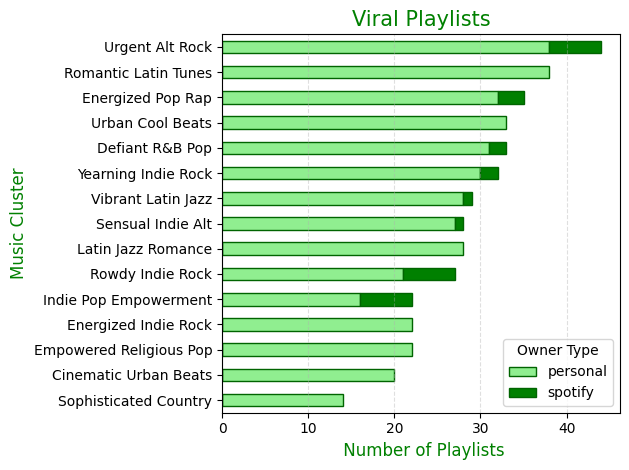

In [61]:
viral_playlist_counts = main_playlists[main_playlists['is_viral'] == 1].groupby(['music_cluster', 'owner_type']).size().unstack(fill_value=0)

# Sort
viral_playlist_counts['total'] = viral_playlist_counts.sum(axis=1)
viral_playlist_counts = viral_playlist_counts.sort_values(by='total').drop(columns='total')

# Plot
plt.figure(figsize=(8, 6))
viral_playlist_counts.plot(kind='barh', stacked=True, color=['lightgreen', 'green'], edgecolor='darkgreen')

# Customizations
plt.title('Viral Playlists', fontsize=15, color='green')
plt.xlabel(' Number of Playlists', fontsize=12, color='green')
plt.ylabel('Music Cluster', fontsize=12, color='green')
plt.legend(title='Owner Type', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 6.3 EVERGREEN playlists

In [62]:
#Evergreen Playlists
# Weights for Evergreen Playlists
evergreen_weights = {'mau': 0.25, #Indicates long-term user base (scale of reach)
                     'monthly_user_retention_rate': 0.35, #% of users returning month-over-month (loyalty)
                     'monthly_streams_per_mau': 0.2, #Engagement depth over a month
                     'monthly_active_user_rate': 0.1, #Audience activity compared to the total potential user base
                     'monthly_user_growth_rate': 0.1} #Long-term growth in the active user base

# Calculating 90% quantiles for metrics
evergreen_quantiles = {metric: main_playlists[metric].quantile(0.9) for metric in evergreen_weights.keys()}

# Calculating Evergreen Score & Label
main_playlists['evergreen_score'] = sum(evergreen_weights[metric] * (main_playlists[metric] > evergreen_quantiles[metric]) for metric in evergreen_weights.keys())
main_playlists['is_evergreen'] = (main_playlists['evergreen_score'] >= 0.5).astype(int)
main_playlists[main_playlists['is_evergreen']==1].shape

(1743, 53)

In [63]:
print('Evergreen playlists form ' + str(round(100*(main_playlists[main_playlists['is_evergreen']==1].shape[0])/main_playlists.shape[0],2)) + '% of the user-base')

Evergreen playlists form 4.35% of the user-base


Distribution of Evergreen playlists across owner_type and music_cluster

<Figure size 800x600 with 0 Axes>

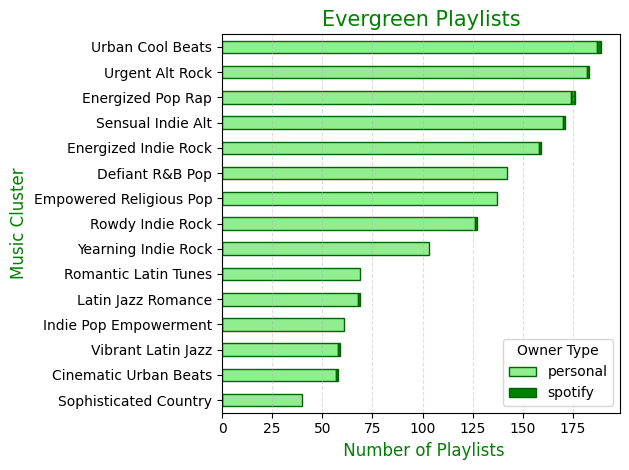

In [64]:
evergreen_playlist_counts = main_playlists[main_playlists['is_evergreen'] == 1].groupby(['music_cluster', 'owner_type']).size().unstack(fill_value=0)

# Sort
evergreen_playlist_counts['total'] = evergreen_playlist_counts.sum(axis=1)
evergreen_playlist_counts = evergreen_playlist_counts.sort_values(by='total').drop(columns='total')

# Plot
plt.figure(figsize=(8, 6))
evergreen_playlist_counts.plot(kind='barh', stacked=True, color=['lightgreen', 'green'], edgecolor='darkgreen')

# Customizations
plt.title('Evergreen Playlists', fontsize=15, color='green')
plt.xlabel(' Number of Playlists', fontsize=12, color='green')
plt.ylabel('Music Cluster', fontsize=12, color='green')
plt.legend(title='Owner Type', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 6.3  NICHE Playlists

In [65]:
#niche playlists
# Weights for Niche Playlists
niche_weights = {'daily_streams_per_track': 0.4, #Reflects user engagement intensity per track.
                 'monthly_user_retention_rate': 0.3, #Measures loyalty in smaller audiences.
                 'owner_monthly_streams_share': 0.20, #reflecting the significant role of owner-driven activity in niche playlists
                 'tracks_per_artist': 0.15, #Indicates focused curation of artists
                 'n_albums': 0.05}#Indicates diversity within a niche playlist

# Calculating 90% quantiles for metrics
niche_quantiles = {metric: main_playlists[metric].quantile(0.9) for metric in niche_weights.keys()}

# Calculating Niche Score & Label
main_playlists['niche_score'] = sum(niche_weights[metric] * (main_playlists[metric] > niche_quantiles[metric]) for metric in niche_weights.keys())
main_playlists['is_niche'] = (main_playlists['niche_score'] >= 0.5).astype(int)
main_playlists[main_playlists['is_niche']==1].shape

(885, 55)

In [66]:
print('Niche playlists form ' + str(round(100*(main_playlists[main_playlists['is_niche']==1].shape[0])/main_playlists.shape[0],2)) + '% of the user-base')

Niche playlists form 2.21% of the user-base


Distribution of Niche playlists across owner_type and music_cluster

<Figure size 800x600 with 0 Axes>

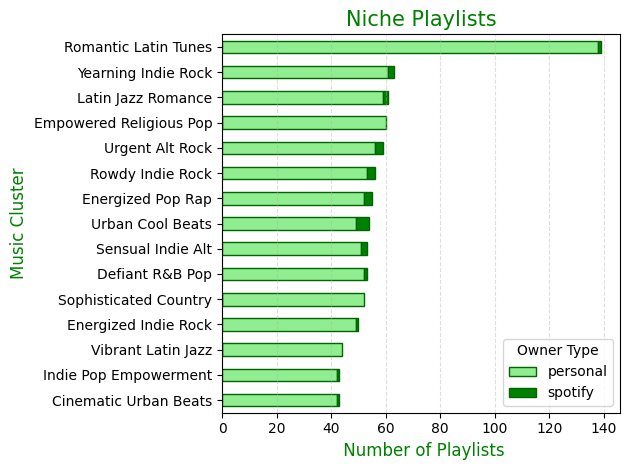

In [67]:
niche_playlist_counts = main_playlists[main_playlists['is_niche'] == 1].groupby(['music_cluster', 'owner_type']).size().unstack(fill_value=0)

# Sort
niche_playlist_counts['total'] = niche_playlist_counts.sum(axis=1)
niche_playlist_counts = niche_playlist_counts.sort_values(by='total').drop(columns='total')

# Plot
plt.figure(figsize=(8, 6))
niche_playlist_counts.plot(kind='barh', stacked=True, color=['lightgreen', 'green'], edgecolor='darkgreen')

# Customizations
plt.title('Niche Playlists', fontsize=15, color='green')
plt.xlabel(' Number of Playlists', fontsize=12, color='green')
plt.ylabel('Music Cluster', fontsize=12, color='green')
plt.legend(title='Owner Type', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## 6.4 SUCCESSFUL Playist

If a playlist is either Viral or Evergreen or Niche, then calling it successful

In [68]:
main_playlists['successful_playlist'] = ((main_playlists['is_viral'] == 1) | (main_playlists['is_evergreen'] == 1) | (main_playlists['is_niche'] == 1)).astype(int)

In [69]:
print('Successful playlists form ' + str(round(100*(main_playlists[main_playlists['successful_playlist']==1].shape[0])/main_playlists.shape[0],2)) + '% of the user-base')

Successful playlists form 6.57% of the user-base


Distribution of Successful playlists across owner_type

In [70]:
main_playlists.groupby(['owner_type'])['successful_playlist'].sum()

,successful_playlist
owner_type,
personal,2581
spotify,51


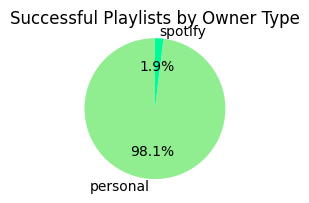

In [71]:
import matplotlib.pyplot as plt

# Assuming 'main_playlists' is your DataFrame and the groupby operation is already performed
playlist_counts_by_owner_type = main_playlists.groupby(['owner_type'])['successful_playlist'].sum()

# Create a pie chart
plt.figure(figsize=(2, 2))
plt.pie(playlist_counts_by_owner_type, labels=playlist_counts_by_owner_type.index, autopct='%1.1f%%', startangle=90, colors=['#90EE90', '#00FA9A'])  # Light green and a slightly darker green
plt.title('Successful Playlists by Owner Type')
plt.axis('equal')

plt.show()

Distribution of Successful playlists across owner_type and music_cluster

<Figure size 800x600 with 0 Axes>

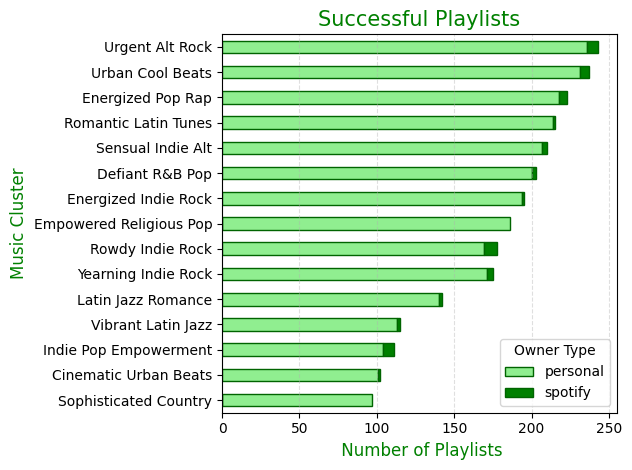

In [72]:
successful_playlist_counts = main_playlists[main_playlists['successful_playlist'] == 1].groupby(['music_cluster', 'owner_type']).size().unstack(fill_value=0)

# Sort
successful_playlist_counts['total'] = successful_playlist_counts.sum(axis=1)
successful_playlist_counts = successful_playlist_counts.sort_values(by='total').drop(columns='total')

# Plot
plt.figure(figsize=(8, 6))
successful_playlist_counts.plot(kind='barh', stacked=True, color=['lightgreen', 'green'], edgecolor='darkgreen')

# Customizations
plt.title('Successful Playlists', fontsize=15, color='green')
plt.xlabel(' Number of Playlists', fontsize=12, color='green')
plt.ylabel('Music Cluster', fontsize=12, color='green')
plt.legend(title='Owner Type', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [74]:
share_metrics = main_playlists[main_playlists['successful_playlist']==1].groupby('music_cluster').agg(
    {'monthly_stream30s': 'sum',
     'mau': 'sum',
     'monthly_owner_stream30s': 'sum',
     'n_tracks': 'sum',
     'n_artists': 'sum',
     'mau_both_months': 'sum',
     'is_viral': 'sum',
     'is_evergreen': 'sum',
     'is_niche': 'sum',
     'successful_playlist': 'sum'
    }
).reset_index()

total_monthly_stream30s = share_metrics['monthly_stream30s'].sum()
total_mau = share_metrics['mau'].sum()
total_monthly_owner_stream30s = share_metrics['monthly_owner_stream30s'].sum()
total_n_tracks = share_metrics['n_tracks'].sum()
total_n_artists = share_metrics['n_artists'].sum()
total_mau_both_months = share_metrics['mau_both_months'].sum()
total_is_viral = share_metrics['is_viral'].sum()
total_is_evergreen = share_metrics['is_evergreen'].sum()
total_is_niche = share_metrics['is_niche'].sum()
total_successful_playlist = share_metrics['successful_playlist'].sum()

share_metrics['monthly_stream30s_share'] = (share_metrics['monthly_stream30s'] / total_monthly_stream30s) * 100
share_metrics['mau_share'] = (share_metrics['mau'] / total_mau) * 100
share_metrics['monthly_owner_stream30s_share'] = (share_metrics['monthly_owner_stream30s'] / total_monthly_owner_stream30s) * 100
share_metrics['n_tracks_share'] = (share_metrics['n_tracks'] / total_n_tracks) * 100
share_metrics['n_artists_share'] = (share_metrics['n_artists'] / total_n_artists) * 100
share_metrics['mau_both_months_share'] = (share_metrics['mau_both_months'] / total_mau_both_months) * 100
share_metrics['is_viral_share'] = (share_metrics['is_viral'] / total_is_viral) * 100
share_metrics['is_evergreen_share'] = (share_metrics['is_evergreen'] / total_is_evergreen) * 100
share_metrics['is_niche_share'] = (share_metrics['is_niche'] / total_is_niche) * 100
share_metrics['successful_playlist_share'] = (share_metrics['successful_playlist'] / total_successful_playlist) * 100

share_metrics.drop(['monthly_stream30s', 'mau', 'monthly_owner_stream30s', 'n_tracks', 'n_artists', 'mau_both_months', 'is_viral', 'is_evergreen', 'is_niche', 'successful_playlist'], axis=1, inplace=True)
for col in share_metrics.columns:
  if '_share' in col:
    share_metrics.rename(columns={col: col.replace('_share', '')}, inplace=True)
share_metrics.rename(columns={'music_cluster': 'Music Cluster',
                              'is_viral':'Viral Playlists',
                              'is_niche':'Niche Playlists',
                              'is_evergreen':'Evergreen Playlists',
                              'successful_playlist':'Successful Playlists',
                              'monthly_stream30s':'Monthly Stream30s',
                              'monthly_owner_stream30s':'Monthly Owner Stream30s',
                              'mau':'MAUs',
                              'mau_both_months':'Loyal MAUs',
                              'n_tracks':'Tracks',
                              'n_artists':'Artists',
                              }, inplace=True)
share_metrics.to_csv('/content/drive/My Drive/Spotify/Percentage share of Music Style across Metrics.csv', index=False)
#Will create graph using Google Sheets
share_metrics

,Music Cluster,Monthly Stream30s,MAUs,Monthly Owner Stream30s,Tracks,Artists,Loyal MAUs,Viral Playlists,Evergreen Playlists,Niche Playlists,Successful Playlists
0,Cinematic Urban Beats,0.67,0.52,3.58,3.00,4.26,0.47,4.68,3.33,4.86,3.88
1,Defiant R&B Pop,1.27,1.33,4.25,5.75,8.20,0.94,7.73,8.15,5.99,7.71
2,Empowered Religious Pop,0.75,0.48,5.25,6.17,6.11,0.53,5.15,7.86,6.78,7.07
3,Energized Indie Rock,30.01,30.30,5.71,10.21,11.20,38.81,5.15,9.12,5.65,7.41
4,Energized Pop Rap,36.47,28.13,6.40,8.79,12.17,35.04,8.20,10.10,6.21,8.47
5,Indie Pop Empowerment,1.26,2.29,2.87,4.29,3.51,0.75,5.15,3.50,4.86,4.22
6,Latin Jazz Romance,0.86,0.79,8.30,5.67,2.74,0.45,6.56,3.96,6.89,5.40
7,Romantic Latin Tunes,3.89,4.48,16.63,2.81,1.47,3.16,8.90,3.96,15.71,8.17
8,Rowdy Indie Rock,3.67,4.74,5.55,6.46,5.43,1.63,6.32,7.29,6.33,6.76
9,Sensual Indie Alt,4.48,5.11,5.38,11.53,9.96,2.32,6.56,9.81,5.99,7.98


In [75]:
print('Spotify owned playlists doubled their percentage share in successful playlists as compare to what they normally have from 1% to 2%')
#contribution of owners who own 10+ playlists in main_playlists
(100*main_playlists[main_playlists['owner_type']=='spotify'].shape[0]/main_playlists.shape[0]

#contribution of owners who own 10+ playlists in only successful playlists
,100*main_playlists[(main_playlists['successful_playlist']==1)&(main_playlists['owner_type']=='spotify')].shape[0]/main_playlists[(main_playlists['successful_playlist']==1)].shape[0])

Spotify owned playlists doubled their percentage share in successful playlists as compare to what they normally have from 1% to 2%


(0.9867106314948042, 1.9376899696048633)

In [76]:
print('Owners owning 10+ playlists doubled their percentage share in successful playlists as compare to what they normally have')
#contribution of owners who own 10+ playlists in main_playlists
(100*main_playlists[main_playlists['owns_10+_playlists']==1].shape[0]/main_playlists.shape[0]

#contribution of owners who own 10+ playlists in only successful playlists
,100*main_playlists[(main_playlists['successful_playlist']==1)&(main_playlists['owns_10+_playlists']==1)].shape[0]/main_playlists[(main_playlists['successful_playlist']==1)].shape[0])

Owners owning 10+ playlists doubled their percentage share in successful playlists as compare to what they normally have


(2.6503796962430055, 4.749240121580547)

In [77]:
cluster_list = main_playlists['music_cluster'].unique()
normal_contribution = []
success_contribution = []
for cat in cluster_list:
  normal_contribution.append(100*main_playlists[main_playlists['music_cluster']==cat].shape[0]/main_playlists.shape[0])
  success_contribution.append(100*main_playlists[(main_playlists['successful_playlist']==1)&(main_playlists['music_cluster']==cat)].shape[0]/main_playlists[(main_playlists['successful_playlist']==1)].shape[0])

music_cluster_success_contribution = pd.DataFrame({'Music Cluster':cluster_list,
               'Normal Contribution':normal_contribution,
               'Successful Contribution':success_contribution})
print('Music clustera that had at least 20% more percentage share in successful playlists than they had normally')
music_cluster_success_contribution[music_cluster_success_contribution['Successful Contribution']>1.1*music_cluster_success_contribution['Normal Contribution']]

Music clustera that had at least 20% more percentage share in successful playlists than they had normally


,Music Cluster,Normal Contribution,Successful Contribution
2,Rowdy Indie Rock,6.04,6.76
5,Energized Pop Rap,6.71,8.47
7,Energized Indie Rock,6.04,7.41
11,Urgent Alt Rock,8.20,9.23


# Step 7 : Predicting if a playlist is successful or not

Assumption : Playlists already having at least 1 month of data will not require predicting if the playlist is going to be successful or not. That can be found through data analysis without using any Machine Learning model.

Based on above assumption, I am making a prediction for only those playlists that have at max 1 day data about users/streams of the playlist

Hence, based on the above reasoning, considering only features in the following cell for prediction:


In [78]:
main_playlists.columns

Index(['playlist_id', 'owner', 'streams', 'stream30s', 'dau', 'wau', 'mau',
       'mau_previous_month', 'mau_both_months', 'users', 'skippers',
       'n_tracks', 'n_local_tracks', 'n_artists', 'n_albums',
       'monthly_stream30s', 'monthly_owner_stream30s', 'tokens', 'genre_1',
       'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3',
       'daily_streams_engagement_rate', 'daily_streams_per_dau',
       'daily_change_in_track_rate', 'daily_skip_rate',
       'daily_streams_per_track', 'monthly_active_user_rate',
       'owner_monthly_streams_share', 'monthly_streams_per_mau',
       'monthly_user_retention_rate', 'monthly_user_growth_rate',
       'weekly_stickiness', 'tracks_per_artist', 'clean_tokens',
       'contains_popular_token', 'token_score', 'length_of_cleaned_tokens',
       'owner_type', 'genre_1_metric', 'genre_2_metric', 'genre_3_metric',
       'mood_1_metric', 'mood_2_metric', 'mood_3_metric', 'music_cluster',
       'owns_10+_playlists', 'viral_score', 'is_viral

In [79]:
prediction_playlist = main_playlists[['playlist_id', 'music_cluster',
                                      'streams', 'stream30s', 'dau', 'skippers',
                                      'n_tracks', 'n_local_tracks', 'n_artists', 'n_albums',
                                      'successful_playlist']]

## 7.1 Logistic Regression

### 7.1.1 Preprocessing for Logistic Regression



In [89]:
#separating features and labels
X = prediction_playlist.drop(['playlist_id', 'successful_playlist'], axis=1)
y = prediction_playlist['successful_playlist']

#One Hot encoding
X = pd.get_dummies(X, columns=['music_cluster'], dummy_na=False)

#Splitting dataset into train, test sets in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7.1.2 Model Training & Predicting

In [90]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.19      0.31      7460
           1       0.08      0.93      0.14       547

    accuracy                           0.24      8007
   macro avg       0.52      0.56      0.23      8007
weighted avg       0.91      0.24      0.30      8007

[[1386 6074]
 [  40  507]]


Accuracy: 0.8072


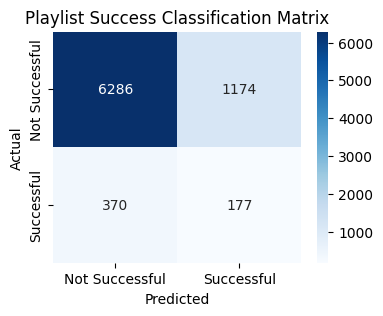

In [91]:
#training
logisticRegression = LogisticRegression(random_state=42,class_weight='balanced')
logisticRegression.fit(X_train, y_train)

#predicting
y_prob_logistic = logisticRegression.predict_proba(X_test)[:, 1]

#setting a custom classification threshold for probability split
threshold = 0.55
y_pred_logistic = (y_prob_logistic >= threshold).astype(int)

#evaluating model performance
accuracy = accuracy_score(y_test, y_pred_logistic)
print(f"Accuracy: {round(accuracy,4)}")

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_logistic)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Successful', 'Successful'], yticklabels=['Not Successful', 'Successful'])
plt.title('Playlist Success Classification Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7.2 LightGBMClassifier

### 7.2.1 Preprocessing for LightGBM
**(please run below cell twice, if next to next cell is not working)**

In [92]:
#separating features and labels
X = prediction_playlist.drop(['playlist_id', 'successful_playlist'], axis=1)
y = prediction_playlist['successful_playlist']

#Label Encoding
le_music_cluster = LabelEncoder()
prediction_playlist['music_cluster'] = le_music_cluster.fit_transform(prediction_playlist['music_cluster']).astype(int)

#le_owner_type = LabelEncoder()
#prediction_playlist['owner_type'] = le_owner_type.fit_transform(prediction_playlist['owner_type']).astype(int)

#Splitting dataset into train, test sets in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7.2.2 Model Training & Predicting

Accuracy: 0.7644561009117022
F1 score: 0.27572964669738864
Precision: 0.17452600875060767
Recall: 0.6563071297989032


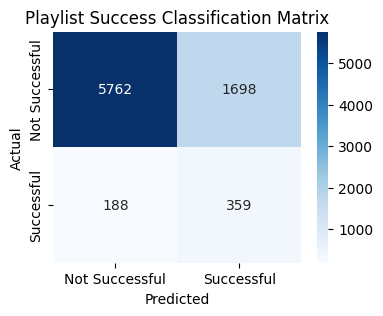

In [93]:
#training
lgbmClassifier = LGBMClassifier(is_unbalance=True,  # Enable class weight handling
                                boosting_type='gbdt',
                                objective='binary',
                                metric='binary_logloss',
                                n_estimators=100,
                                learning_rate=0.1,
                                random_state=42,
                                max_depth =3,
                                verbosity=-1)
lgbmClassifier.fit(X_train, y_train)

#predicting
y_prob_lgbm = lgbmClassifier.predict_proba(X_test)[:, 1]

#setting a custom classification threshold for probability split
threshold = 0.5
y_pred_lgbm = (y_prob_lgbm >= threshold).astype(int)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
#evaluating model performance
accuracy = accuracy_score(y_test, y_pred_lgbm)
f1_score = f1_score(y_test, y_pred_lgbm)
precision_score = precision_score(y_test, y_pred_lgbm)
recall_score = recall_score(y_test, y_pred_lgbm)
print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1_score}")
print(f"Precision: {precision_score}")
print(f"Recall: {recall_score}")

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Successful', 'Successful'], yticklabels=['Not Successful', 'Successful'])
plt.title('Playlist Success Classification Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7.3 RandomForestClassifier

Accuracy: 0.8122892469089547
F1 score: 0.27775108121095626
Precision: 0.18839634941329855
Recall: 0.5283363802559415


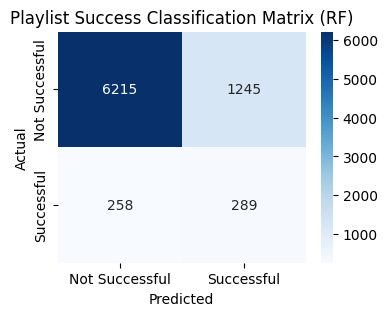

In [94]:
#creating model
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=None,
    class_weight='balanced' # Handle class imbalance
)

#training
rf_classifier.fit(X_train, y_train)

#predicting probabilities
y_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Set a custom classification threshold
threshold = 0.1
y_pred_rf = (y_prob_rf >= threshold).astype(int)

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Successful', 'Successful'], yticklabels=['Not Successful', 'Successful'])
plt.title('Playlist Success Classification Matrix (RF)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 7.4 Comparing ROC_AUC

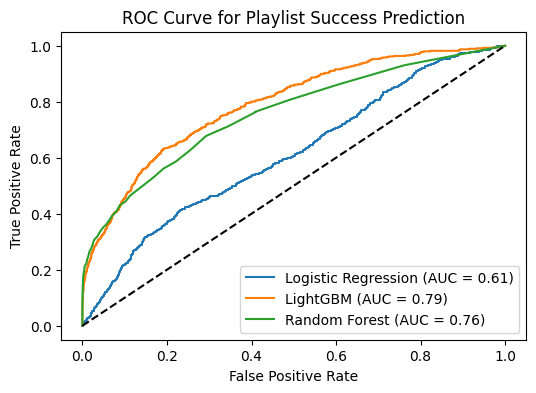

In [95]:
from sklearn.metrics import roc_curve, auc

#ROC_AUC - Logistic Regression
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_prob_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

#ROC_AUC - LightGBM
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

#ROC_AUC - RandomForest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves for both models on the same graph
plt.figure(figsize=(6, 4))
plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM (AUC = %0.2f)' % roc_auc_lgbm)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Playlist Success Prediction')
plt.legend(loc='lower right')
plt.show()

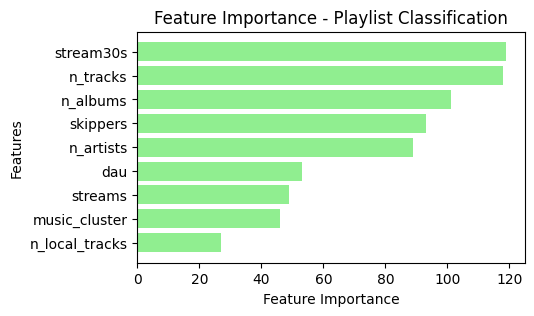

In [96]:
feature_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbmClassifier.feature_importances_
}).sort_values(by='Importance')

# Plot feature importance
plt.figure(figsize=(5, 3))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Playlist Classification')
plt.show()


# Step 7 : Spotipy

In [97]:
pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.7 MB/s eta 0:00:00


In [108]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

SPOTIPY_CLIENT_ID = "ba38754e1d654e19b65a6f3f9413dbec"
SPOTIPY_CLIENT_SECRET = "3a83477342bb40b0b2314877378d50ce"

# Authentication
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [109]:
playlists_spotipy = main_playlists[(main_playlists['is_viral']==1)|(main_playlists['is_evergreen']==1)|(main_playlists['is_niche']==1)|(main_playlists['successful_playlist']==1)|(main_playlists['owner']=='spotify')]
#just saving it to Google drive so I can access this fast wihout eecuting the whole code again in case of runtime out
playlists_spotipy.to_csv('/content/drive/My Drive/Spotify/playlists_spotipy.csv', index=False)

In [110]:
playlists_spotipy = pd.read_csv('/content/drive/My Drive/Spotify/playlists_spotipy.csv')
playlists_spotipy.shape

(2976, 56)

In [111]:
playlists_spotipy['success_score'] = playlists_spotipy['viral_score'] + playlists_spotipy['evergreen_score'] + playlists_spotipy['niche_score']

In [112]:
top10Spotify = playlists_spotipy[(playlists_spotipy['owner']=='spotify')&(playlists_spotipy['successful_playlist']==1)].sort_values(by =['success_score'], ascending=False).reset_index(drop=True)[:10]
top10Spotify.head(1)

,playlist_id,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3,daily_streams_engagement_rate,daily_streams_per_dau,daily_change_in_track_rate,daily_skip_rate,daily_streams_per_track,monthly_active_user_rate,owner_monthly_streams_share,monthly_streams_per_mau,monthly_user_retention_rate,monthly_user_growth_rate,weekly_stickiness,tracks_per_artist,clean_tokens,contains_popular_token,token_score,length_of_cleaned_tokens,owner_type,genre_1_metric,genre_2_metric,genre_3_metric,mood_1_metric,mood_2_metric,mood_3_metric,music_cluster,owns_10+_playlists,viral_score,is_viral,evergreen_score,is_evergreen,niche_score,is_niche,successful_playlist,success_score
0,3O7ce3YlmBnHt5Wi7pLnIu,spotify,3241,1904,276,1208,1208,1,1,1804,302,26,0,26,26,8998,1,"[""qt"", ""family"", ""time""]",Rock,Pop,Alternative,Energizing,Yearning,Sensual,58.75,6.90,0.00,109.42,73.23,66.96,0.01,7.45,100.00,120700.00,1.00,1.00,"['qt', 'family', 'time']",1,2463,3,spotify,0.68,0.91,0.83,0.82,0.88,0.57,Urgent Alt Rock,0,0.50,1,0.80,1,0.70,1,1,2.00


In [113]:
top10Personal = playlists_spotipy[(playlists_spotipy['owner']!='spotify')&(playlists_spotipy['successful_playlist']==1)].sort_values(by =['success_score'], ascending=False).reset_index(drop=True)[:10]
top10Personal.head(1)

,playlist_id,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3,daily_streams_engagement_rate,daily_streams_per_dau,daily_change_in_track_rate,daily_skip_rate,daily_streams_per_track,monthly_active_user_rate,owner_monthly_streams_share,monthly_streams_per_mau,monthly_user_retention_rate,monthly_user_growth_rate,weekly_stickiness,tracks_per_artist,clean_tokens,contains_popular_token,token_score,length_of_cleaned_tokens,owner_type,genre_1_metric,genre_2_metric,genre_3_metric,mood_1_metric,mood_2_metric,mood_3_metric,music_cluster,owns_10+_playlists,viral_score,is_viral,evergreen_score,is_evergreen,niche_score,is_niche,successful_playlist,success_score
0,42kO1lZrGVdOjeuSS0219Y,dc3bdd3ea9a21cddc050e8b1c7240c63,35353,24140,883,1913,3133,1218,707,4143,189,400,27,288,298,433330,755,"[""cleansed"", ""ultimate"", ""playlist""]",Dance & House,Electronica,Alternative,Excited,Defiant,Urgent,68.28,27.34,6.75,21.40,60.35,75.62,0.17,138.31,58.05,157.22,0.61,1.39,"['cleansed', 'ultimate', 'playlist']",1,10812,3,personal,0.62,0.60,0.83,0.92,0.92,0.60,Defiant R&B Pop,0,0.70,1,1.00,1,0.75,1,1,2.45


REMOVE THE [:10] in below code to get insights for all successful playlists in

df1 = playlists_spotipy[:10]

In [117]:
def extract_playlist_info(playlist_id):
    try:
        playlist_info = spotify.playlist(playlist_id)

        if playlist_info:

            mean_days_added_at = None
            mean_track_available_markets = None
            n_explicit_tracks = None
            mean_track_duration_mins = None
            mean_track_popularity = None
            mean_album_available_markets = None
            mean_album_release_year = None

            #check if 'tracks' and 'items' are present
            if 'tracks' in playlist_info and 'items' in playlist_info['tracks']:
                tracks = playlist_info['tracks']['items']

                #days since tracks were added
                days_list = [
                    (datetime.now() - datetime.strptime(track['added_at'], '%Y-%m-%dT%H:%M:%SZ')).days
                    for track in tracks if track['added_at']
                ]
                mean_days_added_at = np.mean(days_list) if days_list else None

                #available markets for tracks
                track_available_markets = [
                    len(track['track']['available_markets'])
                    for track in tracks if 'track' in track and track['track'] and 'available_markets' in track['track']
                ]
                mean_track_available_markets = round(np.mean(track_available_markets), 2) if track_available_markets else None

                #explicit tracks
                explicit_tracks = [
                    track['track']['explicit']
                    for track in tracks if 'track' in track and track['track'] and 'explicit' in track['track']
                ]
                n_explicit_tracks = np.sum(explicit_tracks) if explicit_tracks else 0

                #track duration
                track_duration = [
                    track['track']['duration_ms'] / 60000
                    for track in tracks if 'track' in track and track['track'] and 'duration_ms' in track['track']
                ]
                mean_track_duration_mins = round(np.mean(track_duration), 2) if track_duration else None

                #track popularity
                track_popularity = [
                    track['track']['popularity']
                    for track in tracks if 'track' in track and track['track'] and 'popularity' in track['track']
                ]
                mean_track_popularity = round(np.mean(track_popularity), 2) if track_popularity else None

                #album available markets
                album_available_markets = [
                    len(track['track']['album']['available_markets'])
                    for track in tracks if 'track' in track and track['track'] and 'album' in track['track']
                ]
                mean_album_available_markets = round(np.mean(album_available_markets), 0) if album_available_markets else None

                #album release year
                album_release_year = [
                    int(track['track']['album']['release_date'][:4])
                    for track in tracks if 'track' in track and track['track'] and 'album' in track['track'] and 'release_date' in track['track']['album']
                ]
                mean_album_release_year = round(np.mean(album_release_year),0) if album_release_year else None

            return {
                'collaborative': playlist_info['collaborative'],
                'description': playlist_info['description'],
                'followers': playlist_info['followers']['total'] if playlist_info['followers'] else None,
                'images': playlist_info['images'][0]['url'] if playlist_info['images'] else None,
                'name': playlist_info['name'],
                'owner': playlist_info['owner']['display_name'] if playlist_info['owner'] else None,
                'primary_color': playlist_info['primary_color'] if 'primary_color' in playlist_info else None,
                'public': playlist_info['public'],
                'mean_days_added_at': mean_days_added_at,
                'mean_track_available_markets': mean_track_available_markets,
                'n_explicit_tracks': n_explicit_tracks,
                'mean_track_duration_mins': mean_track_duration_mins,
                'mean_track_popularity': mean_track_popularity,
                'mean_album_available_markets': mean_album_available_markets,
                'mean_album_release_year': mean_album_release_year
            }
        else:
            return None
    except Exception as e:
        return None

#REMOVE THE [:10] to get insights for all successful playlists
df1 = playlists_spotipy[:10]

start = time.time()

#applying above function playlist data
playlist_info_df = df1['playlist_id'].apply(extract_playlist_info).apply(pd.Series)
end = time.time()
print(f"Time taken: {end-start} seconds")

#Adding this new Spotipy data to main playlist level data
df1 = pd.concat([df1, playlist_info_df], axis=1)

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/playlists/2i0HbrNwqR7TTHFFet80W6 with Params: {'fields': None, 'market': None, 'additional_types': 'track'} returned 404 due to Resource not found


Time taken: 2.582105875015259 seconds


UNCOMMENT below lines

In [118]:
#playlist_info_df= playlist_info_df.rename(columns = {'owner':'owner_name','name':'playlist_name'})
#best_playlists = pd.concat([playlists_spotipy, playlist_info_df], axis=1)
#best_playlists.to_csv('/content/drive/My Drive/Spotify/spotipy_data.csv', index=False)
best_playlists = pd.read_csv('/content/drive/My Drive/Spotify/spotipy_data.csv')
best_playlists.shape

(2976, 72)

In [119]:
print('About ' + str(round(100*best_playlists['playlist_name'].isna().sum()/best_playlists.shape[0]))+ '% od successful playlists in the given dataset are not available as of now (deleted)')

About 26% od successful playlists in the given dataset are not available as of now (deleted)


In [120]:
good_metrics = ['playlist_id','streams', 'stream30s', 'dau', 'wau', 'mau',
       'mau_previous_month', 'mau_both_months', 'users', 'skippers',
       'n_tracks', 'n_local_tracks', 'n_artists', 'n_albums',
       'monthly_stream30s', 'monthly_owner_stream30s',

                'daily_streams_engagement_rate', 'daily_streams_per_dau',
       'daily_change_in_track_rate', 'daily_skip_rate',
       'daily_streams_per_track', 'monthly_active_user_rate',
       'owner_monthly_streams_share', 'monthly_streams_per_mau',
       'monthly_user_retention_rate', 'monthly_user_growth_rate',
       'weekly_stickiness', 'tracks_per_artist','contains_popular_token', 'token_score', 'length_of_cleaned_tokens',

                'owns_10+_playlists','is_viral','is_evergreen','is_niche','successful_playlist',

                'collaborative','followers','public',
       'mean_days_added_at', 'mean_track_available_markets',
       'n_explicit_tracks', 'mean_track_duration_mins',
       'mean_track_popularity', 'mean_album_available_markets',
       'mean_album_release_year'
                ]
good_categories = ['owner_type','music_cluster',

                   'collaborative','owns_10+_playlists']

In [121]:
#Changed this cell 50+ times to derive insights in below cell
best_playlists[(best_playlists['successful_playlist']==1)&(~best_playlists['playlist_name'].isna())].groupby(['owner_type','collaborative']).agg({'playlist_id':'count',
                                                                                    'followers':'median',
                                                                                    'stream30s':'median',
                                                                                    'daily_streams_engagement_rate':'median',
                                                                                    'daily_streams_per_dau':'median',
                                                                                    'daily_change_in_track_rate':'median',
                                                                                    'daily_skip_rate':'median',
                                                                                    'daily_streams_per_track':'median',

                                                                                    'monthly_active_user_rate':'median',
                                                                                    'owner_monthly_streams_share':'median',
                                                                                    'monthly_streams_per_mau':'median',
                                                                                    'monthly_user_retention_rate':'median',
                                                                                    'monthly_user_growth_rate':'median',
                                                                                    'weekly_stickiness':'median',
                                                                                    'tracks_per_artist':'median',
                                                                                    'contains_popular_token':'sum',
                                                                                    'token_score':'median',
                                                                                    'length_of_cleaned_tokens':'mean'


                                                                                    })

playlist_id  followers  stream30s  \
owner_type collaborative                                      
personal   False                 1997     110.00      48.00   
           True                    86      31.00      24.00   
spotify    False                   16     196.00    1881.50   

                          daily_streams_engagement_rate  \
owner_type collaborative                                  
personal   False                                  72.73   
           True                                   66.67   
spotify    False                                  63.45   

                          daily_streams_per_dau  daily_change_in_track_rate  \
owner_type collaborative                                                      
personal   False                          10.26                        0.00   
           True                           11.58                        0.00   
spotify    False                           7.81                        0.00   

                          daily_skip_rate  daily_streams_per_track  \
owner_type collaborative                                             
personal   False                    44.44                     0.50   
           True                     33.33                     0.12   
spotify    False                    92.48                    61.08   

                          monthly_active_user_rate  \
owner_type collaborative                             
personal   False                             58.06   
           True                              62.50   
spotify    False                             58.80   

                          owner_monthly_streams_share  \
owner_type collaborative                                
personal   False                                 5.04   
           True                                 18.30   
spotify    False                                 0.00   

                          monthly_streams_per_mau  \
owner_type collaborative                            
personal   False                            35.20   
           True                             53.40   
spotify    False                             9.85   

                          monthly_user_retention_rate  \
owner_type collaborative                                
personal   False                                40.00   
           True                                 50.00   
spotify    False                                13.47   

                          monthly_user_growth_rate  weekly_stickiness  \
owner_type collaborative                                                
personal   False                             27.59               0.36   
           True                              18.71               0.40   
spotify    False                            151.19               0.40   

                          tracks_per_artist  contains_popular_token  \
owner_type collaborative                                              
personal   False                       2.05                     763   
           True                        2.32                      27   
spotify    False                       1.09                       9   

                          token_score  length_of_cleaned_tokens  
owner_type collaborative                                         
personal   False               685.00                      2.43  
           True                494.00                      2.48  
spotify    False              2262.00                      2.50

In [122]:
#######engagement#######
#median daily_streams_engagement_rate is 16% higher in personal than spotify (personal 73, spotify 63)
#median daily_streams_per_dau is 25% higher in personal than spotify (personal 10, spotify 8)
#median daily_streams_per_dau is 25% higher in personal than spotify (personal 10, spotify 8)
#median daily_skip_rate is 48% lower in personal than spotify (personal 44, spotify 92)

#median monthly active user rate is similar across both spotify and personal = 59%
#median monthly_streams_per_mau is 3.6x higher in personal than spotify (personal 36, spotify 10)
#median monthly_user_retention_rate is 3x higher in personal than spotify (personal 40, spotify 13)
#median monthly_user_growth_rate is 82% lower in personal than spotify (personal 27, spotify 151)

#Collaborative playlists
#Low in Reach, Better in engagement
#collaborative playlists have 20% higher monthly_user_retention_rate than non-collab (50,40)
#collaborative playlists have 48% higher monthly_streams_per_mau than non-collab (52,35)
#collaborative playlists have 25% lower daily_skip_rate than non-collab (33,44)
#collaborative playlists have 30% lower monthly_user_growth_rate than non-collab (19,27), and have 3x higher owner_monthly_streams_share (16,5)


##############
#All successful playlists are public

#Personal Mean followers: 5711, Spotify Mean followers: 5711
#Personal Median followers: 105, Spotify Median followers: 196

#Successful playlists have thier tracks/albums available in 70-85 markets average: (70 spotify, 85 personal)

#Successful playlists have 2-5% of explicit tracks (Spotify 5%, Personal 2.5%), except when the music_cluster=Defiant R&B Pop, then 12% explicit tracks in successful playlists

#Successful playlists have tracks close to 4 mins (Spotify 3 min 45 secs, Personal 4 mins )

#Successful playlists have median 50 tracks in spotify while 100 in personal

#Owner streams obviously more in personal

#Only Personal playlists have collaboration
#Collaborative playlists have about 70% less followers as compared to non-Collaborative playlists

In [123]:
pd.options.display.float_format = '{:.0f}'.format
best_playlists[(best_playlists['successful_playlist']==1)&(~best_playlists['playlist_name'].isna())].groupby('owner_type').agg({'playlist_id':'count',
                                                                                    'followers':'median',
                                                                                    'public':'sum',
                                                                                    'mean_track_available_markets':'mean',

                                                                                    'n_tracks':'mean',
                                                                                    'n_explicit_tracks':'mean',
                                                                                    'mean_track_duration_mins':'mean',
                                                                                    'mean_album_release_year':'median'
                                                                                                                                })

,playlist_id,followers,public,mean_track_available_markets,n_tracks,n_explicit_tracks,mean_track_duration_mins,mean_album_release_year
owner_type,,,,,,,,
personal,2083,99,2083,84,316,8,4,2011
spotify,16,196,16,71,78,4,4,2012


In [124]:
#Following music clusters have maximum followers
best_playlists[(best_playlists['successful_playlist']==1)&(~best_playlists['playlist_name'].isna())].groupby('music_cluster').agg({
                                                                                    'followers':'mean'
                                                                                    }).sort_values(by='followers',ascending=False)[:3]

,followers
music_cluster,
Urgent Alt Rock,17892
Yearning Indie Rock,11181
Energized Pop Rap,8393


In [125]:
successful_playlists = best_playlists[(best_playlists['successful_playlist']==1)&(~best_playlists['playlist_name'].isna())]
total_successful_playlists = len(successful_playlists)

viral_percentage = (successful_playlists['is_viral'].sum() / total_successful_playlists) * 100
evergreen_percentage = (successful_playlists['is_evergreen'].sum() / total_successful_playlists) * 100
niche_percentage = (successful_playlists['is_niche'].sum() / total_successful_playlists) * 100

print(f"Percentage of Evergreen Playlists: {evergreen_percentage:.2f}%")
print(f"Percentage of Niche Playlists: {niche_percentage:.2f}%")
print(f"Percentage of Viral Playlists: {viral_percentage:.2f}%")

Percentage of Evergreen Playlists: 63.70%
Percentage of Niche Playlists: 36.02%
Percentage of Viral Playlists: 16.67%


<Axes: >

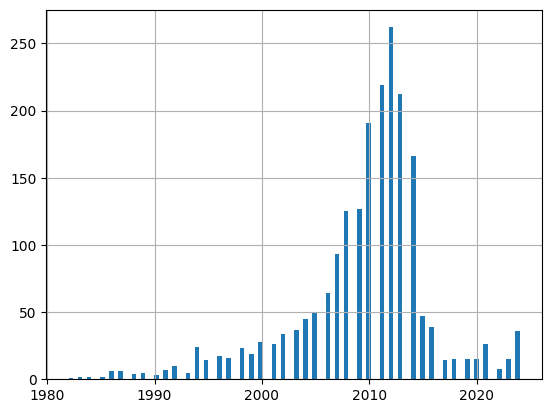

In [126]:
#Most Successfull playists had their albums released in between 2006 to 2014
best_playlists[(best_playlists['mean_album_release_year']>=1980)&(best_playlists['successful_playlist']==1)&(~best_playlists['playlist_name'].isna())]['mean_album_release_year'].hist(bins=100)

<Axes: >

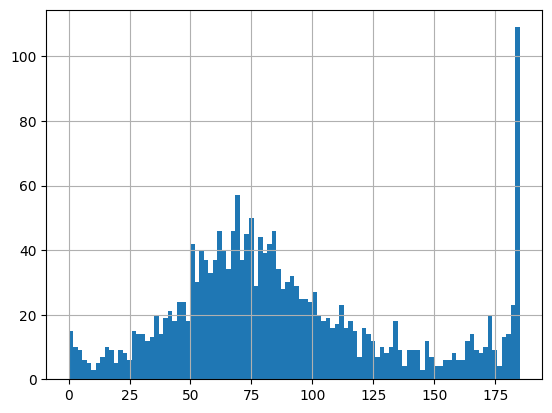

In [127]:
#tracks availablility in markets among successful playlists
best_playlists[(best_playlists['mean_track_available_markets']>0)&(best_playlists['successful_playlist']==1)&(~best_playlists['playlist_name'].isna())]['mean_track_available_markets'].hist(bins=100)

In [131]:
#((results['tracks']['items'][1]['track']['artists'][0]['name'],results['tracks']['items'][1]['track']['artists'][0]['uri']),
#(results['tracks']['items'][1]['track']['artists'][1]['name'],results['tracks']['items'][1]['track']['artists'][1]['uri']))
#spotify.artist('spotify:artist:0du5cEVh5yTK9QJze8zA0C')['followers']['total']
#driving_playlist = spotify.playlist('spotify:playlist:343cAdBctdYlZJPIAtTEPr')

# Optional

Please refer PPT for this